In [5]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import vnn
import torchvision
from imp import reload

In [6]:
#CIFAR

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                            torchvision.transforms.Lambda(lambda x: torch.flatten(x))])
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
def make_fc_net(mono):
    torch.manual_seed(42)
    model = nn.Sequential(vnn.Linear(10, 30720, 200, mono=mono, first_layer=True),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 200, mono=mono),
                          vnn.tReLU(),
                          vnn.Linear(10, 200, 1, mono=mono)).to(0)
    return model


In [19]:
reload(vnn)

def eval_acc(model, loader):
    num_correct = 0
    total = 0
    for batch_idx, (data, labels) in enumerate(loader):
        input = vnn.expand_input(data, 10).to(0)
        with torch.no_grad():
            out = model.forward(input)[..., 0]
        num_correct += (out.argmax(dim=1).cpu() == labels).int().sum().item()
        total += len(data)
    acc = num_correct / total
    return acc

def train_model_local(model, train_loader, test_loader, filename):
    loss_fn = nn.CrossEntropyLoss(reduction="mean")
    opt = optim.Adam(model.parameters(), lr=1e-3)
    acc_vals = np.array([])
    for epoch_idx in range(100):
        print(epoch_idx)
        epoch_loss = 0.
        epoch_correct = 0.
        for batch_idx, (data, labels) in enumerate(train_loader):
            input = vnn.expand_input(data, 10).to(0)
            with torch.no_grad():
                out = model(input)[..., 0]
            loss = loss_fn(out, labels.to(0))
            epoch_loss += loss.item()
            epoch_correct += (out.argmax(dim=1).cpu() == labels).float().sum().item()
            opt.zero_grad()
            vnn.set_model_grads(model, out, labels.to(0))
            opt.step()
            for layer in model: layer.post_step_callback()
        print(epoch_loss / (batch_idx + 1))
        print(epoch_correct / 50000.)
        acc_vals = np.concatenate((acc_vals, [epoch_correct]))
        np.save(filename, acc_vals)
    acc_vals = np.concatenate((acc_vals, [eval_acc(model, test_loader)]))
    np.save(filename, acc_vals)
        
def train_model_bp(model, train_loader, test_loader, filename):
    loss_fn = nn.CrossEntropyLoss(reduction="mean")
    opt = optim.Adam(model.parameters(), lr=1e-3)
    acc_vals = np.array([])
    for epoch_idx in range(100):
        print(epoch_idx)
        epoch_loss = 0.
        epoch_correct = 0.
        for batch_idx, (data, labels) in enumerate(train_loader):
            input = vnn.expand_input(data, 10).to(0)
            out = model(input)[..., 0]
            loss = loss_fn(out, labels.to(0))
            epoch_loss += loss.item()
            epoch_correct += (out.argmax(dim=1).cpu() == labels).float().sum().item()
            opt.zero_grad()
            loss.backward()
            opt.step()
            for layer in model: layer.post_step_callback()
        print(epoch_loss / (batch_idx + 1))
        print(epoch_correct / 50000.)
        acc_vals = np.concatenate((acc_vals, [epoch_correct]))
        np.save(filename, acc_vals)
    acc_vals = np.concatenate((acc_vals, [eval_acc(model, test_loader)]))
    np.save(filename, acc_vals)
        

In [20]:
fc = make_fc_net(False)
train_model_bp(fc, train_loader, test_loader, "results/fc_bp.npy")

fc_mono = make_fc_net(True)
train_model_bp(fc_mono, train_loader, test_loader, "results/fc_mono_bp.npy")

fc = make_fc_net(False)
train_model_local(fc, train_loader, test_loader, "results/fc_local.npy")

fc_mono = make_fc_net(True)
train_model_local(fc_mono, train_loader, test_loader, "results/fc_mono_local.npy")

0
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
Instantiated t with shape (10, 200)
1.9132196525173724
0.35642
1
1.5257844681020283
0.4697
2
1.414855640257716
0.50984
3
1.3389481876207434
0.5389
4
1.268920318549856
0.5647
5
1.2057322842995528
0.58728
6
1.139883323246256
0.60978
7
1.0816144287738654
0.62798
8
1.0215751146111647
0.64744
9
0.9704079855128628
0.66512
10
0.9110988238278557
0.6878
11
0.8549792886999867
0.70664
12
0.8024326390622522
0.72546
13
0.7611154941341761
0.74064
14
0.7062265611518069
0.7568
15
0.6727939343360989
0.77158
16
0.6325789648858483
0.7853
17
0.5941988152006398
0.79594
18
0.5594291172521498
0.80992
19
0.530486926703197
0.8178
20
0.5063430951608111
0.8281
21
0.468737640801598
0.83946
22
0.44667736172218764
0.84688
23
0.42704329264285923
0.85414
24
0.4185230985779287
0.85792
25
0.3927051015674611
0.86826
26
0.37065447489623826
0.87416
27
0.35807948458530103
0.88044

1272.9696134484332
0.8065
58
4106.933101790641
0.81538
59
1435.3066116098857
0.8113
60
2059.426229042775
0.81844
61
1040.586625696753
0.8174
62
1480.9066318599769
0.81664
63
1473.207895478934
0.82492
64
2523.8873703900504
0.82444
65
2995.830912890032
0.8327
66
957.6820276948192
0.82912
67
4350.140643692992
0.83378
68
1672.4775793363372
0.8408
69
3593.6930298671086
0.83666
70
960.7948612105816
0.84866
71
3231.0302566957594
0.84514
72
1794.5450350866292
0.85096
73
1942.332662226294
0.85138
74
5109.693254553754
0.85642
75
791.1594033399812
0.85634
76
4241.929876732399
0.8621
77
3103.4791318108055
0.86262
78
930.2853920392673
0.8582
79
1713.8031560795387
0.86424
80
2258.2635520291146
0.8669
81
1737.4922664866729
0.86322
82
2440.321389942218
0.86748
83
1730.608970388427
0.87074
84
2632.509545289647
0.87056
85
2356.9615588175975
0.87544
86
6595.487838823167
0.88068
87
1313.0130638259145
0.8825
88
2346.2021131588676
0.88076
89
1920.6130453631702
0.8883
90
7629.648033278678
0.88142
91
1608.238

In [21]:
x1 = np.load("results/fc_bp.npy")
x2 = np.load("results/fc_mono_bp.npy")
x3 = np.load("results/fc_local.npy")
x4 = np.load("results/fc_mono_local.npy")



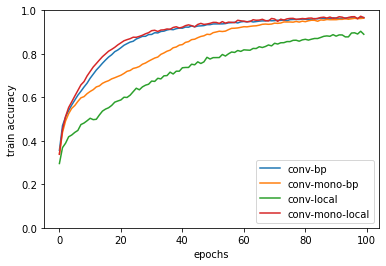

In [25]:
N = 50000.
plt.plot(x1[:-1]/N, label="conv-bp")
plt.plot(x2[:-1]/N, label="conv-mono-bp")
plt.plot(x3[:-1]/N, label="conv-local")
plt.plot(x4[:-1]/N, label="conv-mono-local")
plt.ylim(0, 1)
plt.legend()
plt.ylabel("train accuracy")
plt.xlabel("epochs")
plt.savefig("figs/fc_acc.pdf", bbox_inches="tight")


In [24]:
[x[-1] for x in (x1, x2, x3, x4)]

[0.5078, 0.5054, 0.4727, 0.5042]